In [1]:
import os
import warnings
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torchvision

from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
import json
import re

from utils import test_model, compare_models_prediction, generate_z_samples
from zoo_utils import load_hyperrep_edx

from shrp.models.def_net import CNN, CNN3
from shrp.models.def_AE_trainable import get_transformations
from shrp.datasets.dataset_auxiliaries import tokens_to_recipe, tokens_to_checkpoint
from shrp.models.def_loss import DistillationLoss, ReconDistillationLoss

/netscratch2/lmeynent/research/structure_vs_behaviour/zoo_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context='notebook', style='whitegrid',
              rc={
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'xtick.bottom': True,
                  'ytick.left': True,
                  'font.family': 'Fira Sans'
              })

COLOURS = [
    '#960018',  # Carmine Red
    '#FED85D',  # Mustard Gold
    '#434384',  # Marian Blue
    '#54B674',  # Emerald Green
    '#D183C9',  # French Mauve
    '#318CE7',  # French Blue
    '#D08000'   # Fulvous Orange
]

## Loading data

In [4]:
DATASETS = ['svhn', 'cifar10', 'eurosat']
DATASET_LABELS = {
    'svhn': 'SVHN',
    'cifar10': 'CIFAR-10',
    'eurosat': 'EuroSAT'
}

DS_ORDER = ['SVHN', 'CIFAR-10', 'EuroSAT']
HR_ORDER = ['Contrastive + Structure (Baseline)', 'Contrastive + Structure + Behavior']

HYPERREP_PATH = Path('/netscratch2/lmeynent/research/structure_vs_behaviour/results/hyperrepresentations/tune')

In [5]:
MAX_EPOCH = 100

df_hr = pd.DataFrame(columns=[
    'Model zoo',
    'Trial ID',
    'Learning rate',
    'Latent dimension',
    'Behaviour loss',
    'Query set',
    'Query dataset',
    '# of queries',
    'Gamma',
    'Beta',
    'Epoch',
    'Train loss',
    'Train loss (contrast)', 
    'Train loss (recon)',
    'Train loss (structure)', 
    'Train loss (behaviour)',
    'Test loss',
    'Test loss (contrast)', 
    'Test loss (recon)',
    'Test loss (structure)', 
    'Test loss (behaviour)',
    'Dstk: Test accuracy',
    'Dstk: GGap'
])

for ds in tqdm(DATASETS, desc='Loading data', unit='dataset'):
    hr_path = HYPERREP_PATH / f"{ds}_train_hyperrep"
    for path in os.listdir(hr_path):
        if not re.match('AE_trainable', path):
            continue
        path = hr_path / path

        with open(path / 'params.json') as ifh_config, open(path / 'result.json') as ifh_result:
            config = json.load(ifh_config)
            result = pd.read_json(ifh_result, lines=True, dtype={'trial_id': str})

        for edx in range(len(result)):
            df_hr.loc[len(df_hr)] = (
                DATASET_LABELS[ds],
                result.loc[edx]['trial_id'],
                config['optim::lr'],
                config['ae:lat_dim'],
                config['training::loss_distillation'],
                config['training::queryset_distillation'],
                config['training::queryset_dump'],
                config['training::n_queries_distillation'],
                config['training::gamma'],
                config['training::beta'],
                result.loc[edx]['training_iteration'],
                result.loc[edx]['loss/loss_train'],
                result.loc[edx]['loss/loss_contrast_train'],
                result.loc[edx]['loss/loss_recon_train'],
                result.loc[edx]['loss/loss_structure_train'],
                result.loc[edx]['loss/loss_behaviour_train'],
                result.loc[edx]['loss/loss_test'],
                result.loc[edx]['loss/loss_contrast_test'],
                result.loc[edx]['loss/loss_recon_test'],
                result.loc[edx]['loss/loss_structure_test'],
                result.loc[edx]['loss/loss_behaviour_test'],
                result.loc[edx]['dstk/test_acc_test'],
                result.loc[edx]['dstk/ggap_test']
            )

df_hr['Query dataset'] = df_hr['Query dataset'].map({
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/svhn_train_zoo_relu/dataset.pt': 'SVHN',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/cifar10_train_zoo_relu/dataset.pt': 'CIFAR-10',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/eurosat_train_zoo_relu/dataset.pt': 'EuroSAT',
    '/netscratch2/lmeynent/research/structure_vs_behaviour/results/data/tinyimagenet_32/dataset.pt': 'TinyImagenet-32'
})
df_hr.head()

Loading data:   0%|          | 0/3 [00:00<?, ?dataset/s]

,Model zoo,Trial ID,Learning rate,Latent dimension,Behaviour loss,Query set,Query dataset,# of queries,Gamma,Beta,...,Train loss (recon),Train loss (structure),Train loss (behaviour),Test loss,Test loss (contrast),Test loss (recon),Test loss (structure),Test loss (behaviour),Dstk: Test accuracy,Dstk: GGap
0,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,1.344194,0.930796,1.390127,1.059503,1.045855,1.060222,0.791913,1.090034,0.559680,0.283559
1,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.275532,0.770928,0.220488,0.257198,0.887651,0.224016,0.591360,0.183200,0.554503,0.276677
2,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.266038,0.677502,0.220320,0.247892,0.708432,0.223653,0.544859,0.187963,0.550643,0.276275
3,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.264123,0.664841,0.219599,0.239949,0.652948,0.218212,0.527920,0.183800,0.551713,0.279411
4,SVHN,50f57_00020,0.00001,64,cross_entropy,data,SVHN,256,0.05,0.1,...,0.261248,0.628665,0.220424,0.242219,0.741064,0.215964,0.495595,0.184894,0.538348,0.282729


In [6]:
idx_dict = {
    '00011': 'Contrastive + Structure (Baseline)',
    '00000': 'Behavior',
    '00006': 'Contrastive + Behavior',
    '00002': 'Structure + Behavior',
    '00008': 'Contrastive + Structure + Behavior'
}

df_hr['Hyper-representation'] = df_hr['Trial ID'].str.slice(start=-5).map(idx_dict)

## Analysing data

### Predicting test accuracy

In [7]:
df_dstk = df_hr[df_hr['Epoch'] == MAX_EPOCH]
df_dstk = df_dstk.groupby(['Hyper-representation', 'Model zoo'])['Dstk: Test accuracy'].mean().reset_index().pivot(index='Hyper-representation', columns='Model zoo', values='Dstk: Test accuracy')
df_dstk = df_dstk.loc[HR_ORDER, DS_ORDER]
df_dstk.loc['Difference'] = df_dstk.loc['Contrastive + Structure + Behavior'] - df_dstk.loc['Contrastive + Structure (Baseline)']
df_dstk = df_dstk.style.format(precision=3)
print(df_dstk.to_latex())
df_dstk

\begin{tabular}{lrrr}
Model zoo & SVHN & CIFAR-10 & EuroSAT \\
Hyper-representation &  &  &  \\
Contrastive + Structure (Baseline) & 0.742 & 0.890 & 0.957 \\
Behavior & 0.538 & 0.771 & 0.901 \\
Contrastive + Behavior & 0.752 & 0.893 & 0.950 \\
Structure + Behavior & 0.887 & 0.939 & 0.966 \\
Contrastive + Structure + Behavior & 0.886 & 0.947 & 0.969 \\
Difference & 0.144 & 0.056 & 0.012 \\
\end{tabular}



Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation,,,
Contrastive + Structure (Baseline),0.742,0.890,0.957
Behavior,0.538,0.771,0.901
Contrastive + Behavior,0.752,0.893,0.950
Structure + Behavior,0.887,0.939,0.966
Contrastive + Structure + Behavior,0.886,0.947,0.969
Difference,0.144,0.056,0.012


### Predicting generalization gap

In [8]:
df_dstk = df_hr[df_hr['Epoch'] == MAX_EPOCH]
df_dstk = df_dstk.groupby(['Hyper-representation', 'Model zoo'])['Dstk: GGap'].mean().reset_index().pivot(index='Hyper-representation', columns='Model zoo', values='Dstk: GGap')
df_dstk = df_dstk.loc[HR_ORDER, DS_ORDER]
df_dstk.loc['Difference'] = df_dstk.loc['Contrastive + Structure + Behavior'] - df_dstk.loc['Contrastive + Structure (Baseline)']
df_dstk = df_dstk.style.format(precision=3)
print(df_dstk.to_latex())
df_dstk

\begin{tabular}{lrrr}
Model zoo & SVHN & CIFAR-10 & EuroSAT \\
Hyper-representation &  &  &  \\
Contrastive + Structure (Baseline) & 0.347 & 0.700 & 0.465 \\
Behavior & 0.286 & 0.576 & 0.296 \\
Contrastive + Behavior & 0.337 & 0.710 & 0.482 \\
Structure + Behavior & 0.378 & 0.785 & 0.484 \\
Contrastive + Structure + Behavior & 0.368 & 0.785 & 0.529 \\
Difference & 0.021 & 0.085 & 0.063 \\
\end{tabular}



Model zoo,SVHN,CIFAR-10,EuroSAT
Hyper-representation,,,
Contrastive + Structure (Baseline),0.347,0.700,0.465
Behavior,0.286,0.576,0.296
Contrastive + Behavior,0.337,0.710,0.482
Structure + Behavior,0.378,0.785,0.484
Contrastive + Structure + Behavior,0.368,0.785,0.529
Difference,0.021,0.085,0.063


### Plotting discriminative downstream tasks

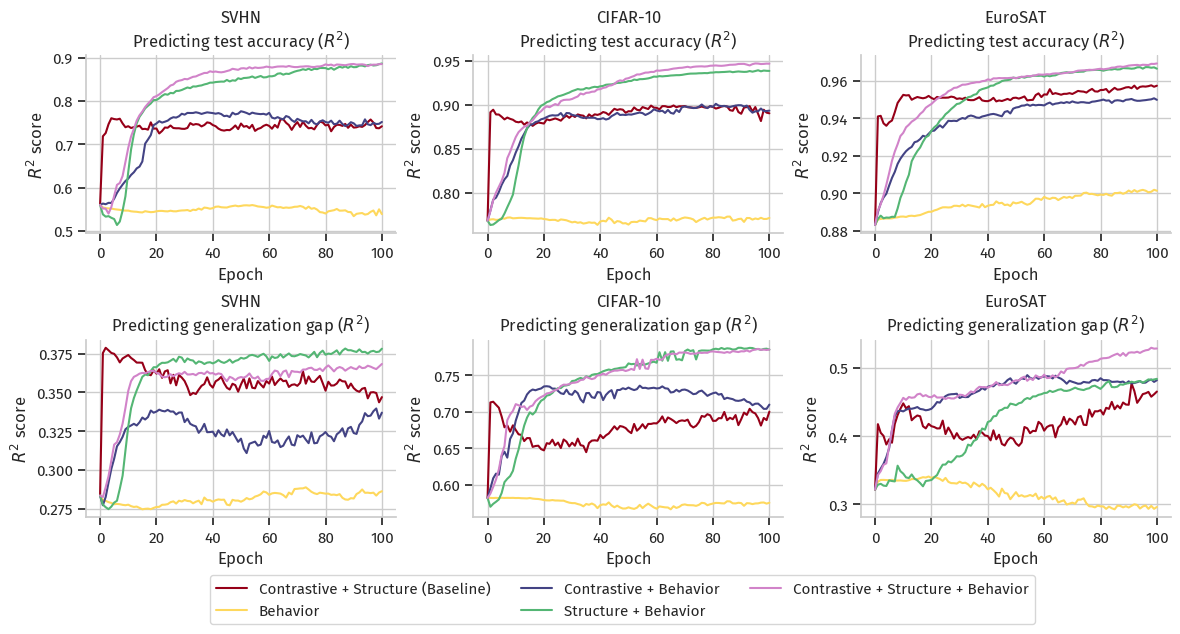

In [9]:
_, axs = plt.subplots(2, 3, figsize=(14, 6))

for d, ds in enumerate(DATASETS):
    ds_label = DATASET_LABELS[ds]
    
    df_hr_plot = df_hr[df_hr['Model zoo'] == ds_label]
    
    for i, (idx, label) in enumerate(idx_dict.items()):
        sns.lineplot(df_hr_plot[df_hr_plot['Hyper-representation'] == label], x='Epoch', y='Dstk: Test accuracy', color=COLOURS[i], label=label, ax=axs[0][d])
        sns.lineplot(df_hr_plot[df_hr_plot['Hyper-representation'] == label], x='Epoch', y='Dstk: GGap', color=COLOURS[i], label=label, ax=axs[1][d])
    
    axs[0][d].set(title=f"{ds_label}\nPredicting test accuracy ($R^2$)", ylabel='$R^2$ score')
    axs[0][d].get_legend().remove()
    
    axs[1][d].set(title=f"{ds_label}\nPredicting generalization gap ($R^2$)", ylabel='$R^2$ score')
    axs[1][d].get_legend().remove()

plt.legend(loc=(-2.1, -0.60), ncols=3)
plt.subplots_adjust(hspace=0.6, wspace=0.25)
plt.savefig('figures/discriminative_dstk.png', dpi=300, bbox_inches='tight')
plt.show()